In [71]:
import echopype as ep
import xarray as xr
import numpy as np
import dask_image.ndfilters
import dask
from typing import Union

from echopype.utils.compute import _lin2log, _log2lin
from echopype.commongrid.utils import _parse_x_bin

In [33]:
ed = ep.open_raw("echopype/test_data/ek60/from_echopy/JR161-D20061118-T010645.raw", sonar_model="EK60")
ds_Sv = ep.calibrate.compute_Sv(ed)
ds_Sv = ep.consolidate.add_depth(ds_Sv)
ds_Sv = ds_Sv.isel(ping_time=slice(100,120), range_sample=slice(1000,1020))
#ds_Sv["Sv"][dict(ping_time=2, range_sample=2)] = np.nan
func="nanmedian"

In [4]:
_lin2log(
    np.nanmean(
        ds_Sv["Sv"].pipe(_log2lin).isel(channel=0)
    )
)

-66.64169831485304

In [5]:
ds_Sv["Sv"].isel(channel=0).data

array([[-59.89349382, -62.67968629, -67.06510775, -70.53333972,
        -86.94822799],
       [-65.9493715 , -64.51409029, -65.06608431, -69.43975756,
        -84.02023422],
       [-66.7136995 , -68.18289064,          nan, -66.62935565,
        -71.86144363],
       [-65.89057176, -71.20494722, -78.43604891, -79.30554125,
        -73.70760452],
       [-63.69164292, -64.8550937 , -66.97103732, -66.24130938,
        -71.5674678 ]])

In [6]:
dask_image.ndfilters.median_filter(ds_Sv["Sv"].isel(channel=0).chunk("auto").data, size=3).compute()

array([[-62.67968629, -64.51409029, -67.06510775, -70.53333972,
        -84.02023422],
       [-65.9493715 , -67.06510775, -67.06510775, -70.53333972,
        -71.86144363],
       [-65.9493715 , -66.7136995 , -68.18289064, -71.86144363,
        -73.70760452],
       [-65.89057176,          nan, -66.97103732, -66.24130938,
        -71.86144363],
       [-64.8550937 , -65.89057176, -66.97103732, -71.5674678 ,
        -71.5674678 ]])

In [7]:
_lin2log(
    dask_image.ndfilters.generic_filter(
        ds_Sv["Sv"].chunk("auto").pipe(_log2lin).data,
        function=np.nanmedian,
        size=(1, 3,3),
        mode="constant",
        cval=np.nan
    )
)

dask.array<mul, shape=(3, 5, 5), dtype=float64, chunksize=(3, 5, 5), chunktype=numpy.ndarray>

In [8]:
_lin2log(
    np.nanmedian(
        ds_Sv["Sv"].pipe(_log2lin).isel(channel=0, ping_time=slice(1,4), range_sample=slice(1,4))
    )
)

-68.76601405637089

In [9]:
"""
from dask.distributed import Client
client = Client(n_workers=2)
print(client.dashboard_link)
"""

'\nfrom dask.distributed import Client\nclient = Client(n_workers=2)\nprint(client.dashboard_link)\n'

In [101]:
def uniform_depth_calc_transient_noise_pooled_Sv(
    ds_Sv: xr.Dataset, func: str, depth_bin: int, num_side_pings: int, exclude_above: float
) -> xr.DataArray:
    """
    Compute pooled Sv array for transient noise masking.
    """
    # Create `ds_Sv` copy
    ds_Sv_copy = ds_Sv.copy().drop_dims("filenames").transpose("channel", "ping_time","range_sample")

    # Compute number of range sample indices are needed to encapsulate the `depth_bin`
    # value per channel.
    all_chan_num_range_sample_indices = np.ceil(
        depth_bin / np.nanmean(
            np.diff(ds_Sv_copy["depth"], axis=2), axis=(1,2)
        )
    ).astype(int)

    # Create list for pooled Sv DataArrays
    pooled_Sv_list = []

    # Iterate through channels
    for channel_index in range(len(ds_Sv_copy["channel"])):
        # Create calibrated Sv DataArray copies and remove values too close to the surface
        min_range_sample = (ds_Sv["depth"] <= exclude_above).argmin().values
        chan_Sv = ds_Sv_copy["Sv"].copy().isel(
            channel=channel_index,
            range_sample=slice(min_range_sample, len(ds_Sv["range_sample"]))
        )
        chan_pooled_Sv = ds_Sv_copy["Sv"].copy().isel(
            channel=channel_index,
            range_sample=slice(min_range_sample, len(ds_Sv["range_sample"]))
        )

        # Grab channel-specific number of range sample indices for vertical binning
        chan_num_range_sample_indices = all_chan_num_range_sample_indices[channel_index]

        # Create pooling size list
        pooling_size = [(2 * num_side_pings) + 1, (2 * chan_num_range_sample_indices) + 1]

        # Rechunk Sv if already computed. Rechunking is needed to turn the inner Numpy
        # Array to a Dask Array, since `dask_image.ndfilter.generic_filter` requires
        # a Dask Array.
        if not (hasattr(chan_Sv, "chunks") and chan_Sv.chunks is not None):
            # Chunk based on pooling sizes
            chan_Sv = chan_Sv.chunk({"ping_time": pooling_size[0], "range_sample": pooling_size[1]})

        # Compute `chan_pooled_Sv` values using dask-image's generic filter
        chan_pooled_Sv.values = _lin2log(
            dask_image.ndfilters.generic_filter(
                chan_Sv.pipe(_log2lin).data,
                function=np.nanmean if func == "nanmean" else np.nanmedian,
                size=pooling_size,
                mode="constant",
                cval=np.nan,
            )
        )

        # Subset valid pooled Sv values too close to the edge of the echogram
        chan_pooled_Sv = chan_pooled_Sv.isel(
            ping_time=slice(num_side_pings, -num_side_pings),
            range_sample=slice(chan_num_range_sample_indices, -chan_num_range_sample_indices),
        )

        # Expand `chan_pooled_Sv` to original Sv dimensions, turning the previously
        # mentioned invalid values into `NaNs`.
        chan_pooled_Sv = chan_pooled_Sv.reindex_like(ds_Sv_copy["Sv"].isel(channel=channel_index))

        # Place in pooled Sv list
        pooled_Sv_list.append(chan_pooled_Sv)

    # Concatenate arrays along channel dimension
    pooled_Sv = xr.concat(pooled_Sv_list, dim="channel")

    return pooled_Sv

In [93]:
depth_bin = _parse_x_bin("1m", "range_bin")

num_range_sample_indices = np.ceil(
    depth_bin / np.nanmean(
        np.diff(ds_Sv["depth"].transpose("channel", "ping_time", "range_sample"), axis=2), axis=(1,2)
    )
)
print(num_range_sample_indices)

[6. 6. 6.]


In [102]:
pooled_Sv = uniform_depth_calc_transient_noise_pooled_Sv(
    ds_Sv, "nanmean", 1, 1, 250
).compute()

3


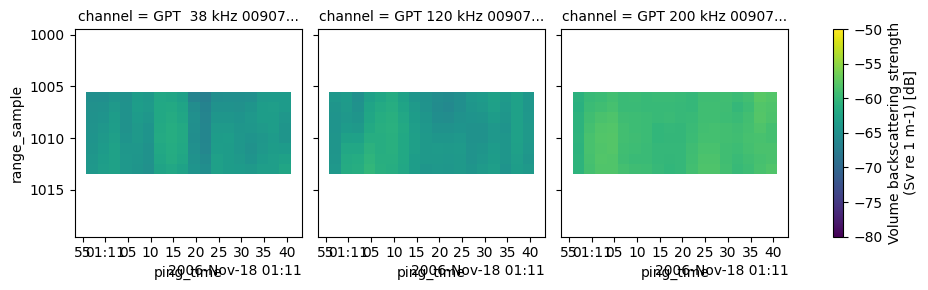

In [99]:
pooled_Sv.plot(col="channel", y="range_sample", yincrease=False, vmin=-80, vmax=-50)

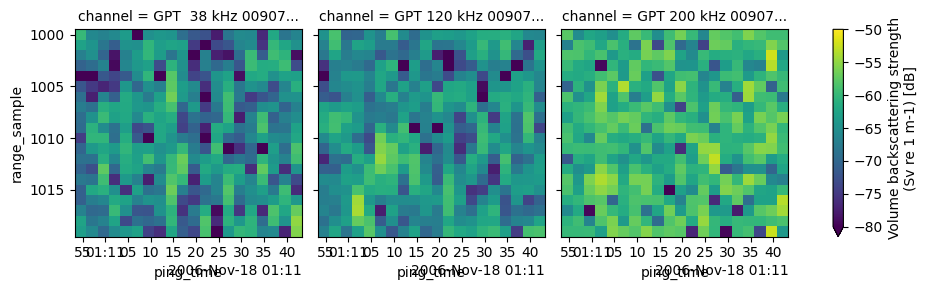

In [100]:
ds_Sv["Sv"].plot(col="channel", y="range_sample", yincrease=False, vmin=-80, vmax=-50)